# Project: Identify Customer Segments
by Baily Jepsen

## Introduction
In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
n_rows = azdias.shape[0]
n_cols = azdias.shape[1]

print('AZDIAS Dataset Shape')
print('Rows: {}'.format(n_rows))
print('Columns: {}'.format(n_cols))

n_rows = feat_info.shape[0]
n_cols = feat_info.shape[1]

print('\nAZDIAS Feature Summary Shape')
print('Rows: {}'.format(n_rows))
print('Columns: {}'.format(n_cols))

AZDIAS Dataset Shape
Rows: 891221
Columns: 85

AZDIAS Feature Summary Shape
Rows: 85
Columns: 4


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [8]:
pre_missing_vals = azdias.isnull().values.sum()
print('Count of missing values: {}'.format(pre_missing_vals))

Count of missing values: 4896838


In [9]:
# Identify missing or unknown data values and convert them to NaNs.
count = 0

for index in range(len(feat_info)):
    # Parse and clean `missing_or_unknown` values from `feat_info`
    nan_data = feat_info.iloc[index]['missing_or_unknown']
    nan_data = nan_data.strip('[]')
    nan_data = nan_data.split(sep=',')
    
    # If the `missing_or_unknown` value is not "X", "XX", or empty then convert to an int
    nan_data = [int(value) if (value!='X' and value!='XX' and value!='') 
                else value for value in nan_data]
    
    if nan_data != ['']:
        # Replace missing or unkown values in the dataset with NaNs
        azdias = azdias.replace({feat_info.iloc[index]['attribute']: nan_data}, np.nan)
        count += 1

In [10]:
post_missing_vals = azdias.isnull().values.sum()

print('Columns impacted: {}/85'.format(count))
print('Values impacted: {}'.format(post_missing_vals - pre_missing_vals))
print('Count of missing values after conversion: {}'.format(post_missing_vals))

Columns impacted: 75/85
Values impacted: 3477091
Count of missing values after conversion: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset

# Quick check for columns that have no missing values
null_cols = azdias.isnull().sum()
null_cols.sort_values(inplace=True)
print(null_cols)

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [12]:
# Convert the number of missing values to a percentage 
# for columns with missing values
percent_missing = null_cols[null_cols > 0] / azdias.shape[0] * 100
print(percent_missing.sort_values())

ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
CJT_GESAMTTYP             0.544646
HH_EINKOMMEN_SCORE        2.058749
WOHNDAUER_2008            8.247000
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
GEBAEUDETYP              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
BALLRAUM                 10.518154
EWDICHTE                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

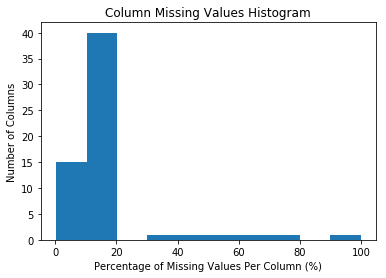

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing);
plt.title('Column Missing Values Histogram');
plt.xlabel('Percentage of Missing Values Per Column (%)');
plt.ylabel('Number of Columns');

In [14]:
# The majority of the columns are composed of less than 20% missing values.
# Find the columns that are composed of more than 20% missing values.
percent_missing[percent_missing >  20]

ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
azdias.drop(columns=outliers, axis='outliers', inplace=True)

# Ensure that columns composed of more than 20% missing values were 
# removed
null_cols = azdias.isnull().sum()
null_cols.sort_values(inplace=True)
percent_missing = null_cols[null_cols > 0] / (azdias.shape[0]) * 100
print(percent_missing.sort_values())

ALTERSKATEGORIE_GROB      0.323264
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
GFK_URLAUBERTYP           0.544646
CJT_GESAMTTYP             0.544646
HH_EINKOMMEN_SCORE        2.058749
SOHO_KZ                   8.247000
WOHNDAUER_2008            8.247000
ANZ_TITEL                 8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
RELAT_AB                 10.926022
ARBEIT                   10.926022
LP_LEBENSPHASE_FEIN 

#### Discussion 1.1.2: Assess Missing Data in Each Column

I began my approach with finding the proportion of missing values for each column. I then created a histogram using these proportions, showing that the majority of the data (55/61 columns) is composed of less than 20% missing values. Querying `null_data` for columns with more than 20% missing values produced `ALTER_HH` (34.813699%), `GEBURTSJAHR` (44.020282%), `KBA05_BAUMAX` (53.468668%), `KK_KUNDENTYP` (65.596749%), `AGER_TYP` (76.955435%), and `TITEL_KZ` (99.757636%). These six columns are the outliers and were removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?
null_rows = azdias.isnull().sum(axis=1)
null_rows.sort_values(inplace=True)
null_rows

445610     0
540274     0
540275     0
540277     0
540280     0
540281     0
540283     0
540284     0
540286     0
540273     0
540287     0
540290     0
540291     0
540292     0
540293     0
540295     0
540296     0
540298     0
540299     0
540289     0
540300     0
540271     0
540269     0
540239     0
540240     0
540241     0
540242     0
540243     0
540244     0
540246     0
          ..
139521    47
690887    47
690878    47
690876    47
690871    47
139478    47
139236    47
691118    47
691129    47
691317    47
139243    47
139245    47
139248    47
139250    47
139255    47
139267    47
691122    47
691212    47
139323    47
691197    47
139332    47
691183    47
691171    47
691142    47
691141    47
139316    47
183108    47
472919    48
732775    49
643174    49
Length: 891221, dtype: int64

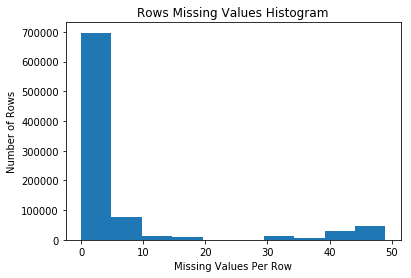

In [17]:
plt.hist(null_rows);
plt.title('Rows Missing Values Histogram');
plt.xlabel('Missing Values Per Row');
plt.ylabel('Number of Rows');

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
less_missing = azdias[azdias.isnull().sum(axis=1) <= 20]
more_missing = azdias[azdias.isnull().sum(axis=1) > 20]

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_outliers = null_cols[null_cols < 20]
no_outliers

ZABEOTYP                 0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
GREEN_AVANTGARDE         0
SEMIO_PFLICHT            0
FINANZTYP                0
FINANZ_HAUSBAUER         0
FINANZ_UNAUFFAELLIGER    0
FINANZ_ANLEGER           0
FINANZ_VORSORGER         0
FINANZ_SPARER            0
FINANZ_MINIMALIST        0
SEMIO_TRADV              0
ANREDE_KZ                0
SEMIO_SOZ                0
SEMIO_FAM                0
dtype: int64

In [20]:
target_cols = no_outliers.index[:5]
target_cols

Index(['ZABEOTYP', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST'], dtype='object')

In [21]:
# I wrestled with this function, but the matplotlib subplot 
# documentation helped with using tuple unpacking for multiple Axes
# (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

def plots_for_column(col):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)

    ax1.set_title('Subset Missing <=20 Values')
    sns.countplot(azdias.loc[less_missing.index, col], ax=ax1)
    
    ax2.set_title('Subset Missing >20 Values')
    sns.countplot(azdias.loc[more_missing.index, col], ax=ax2)

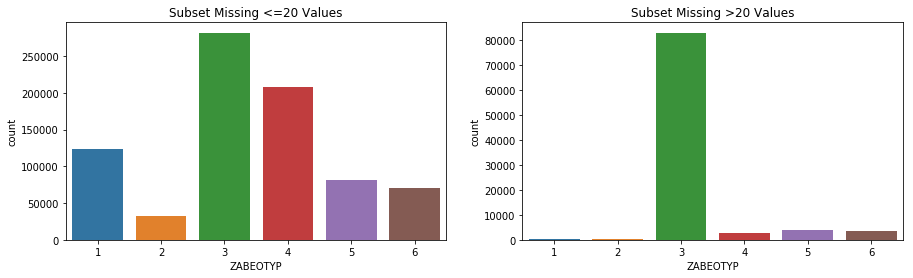

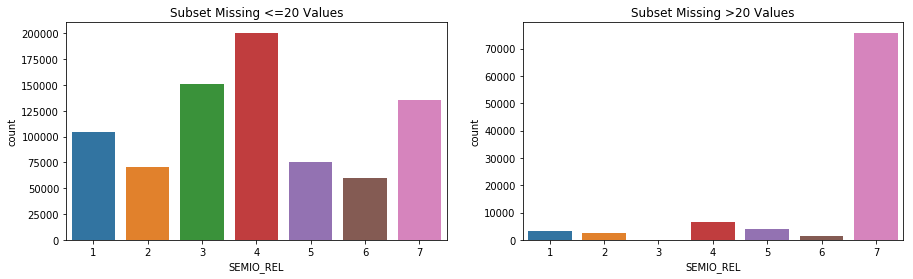

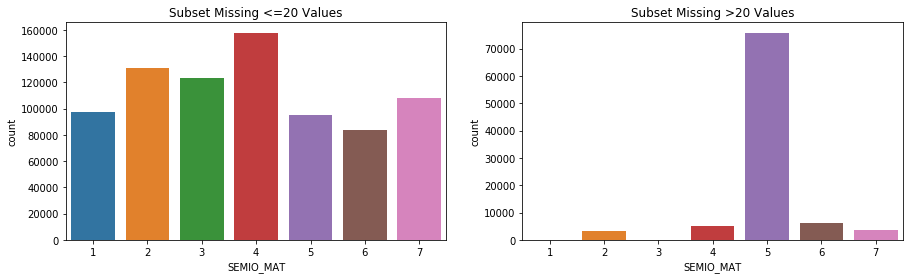

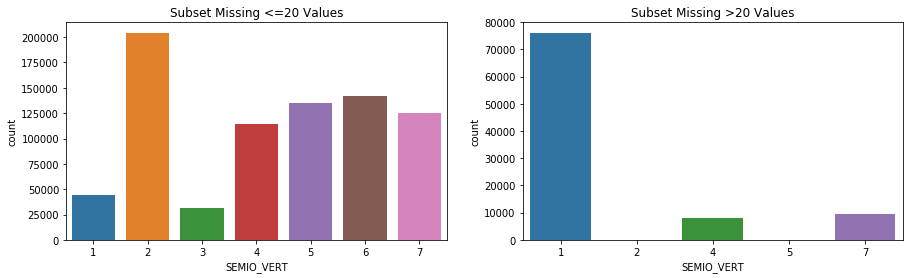

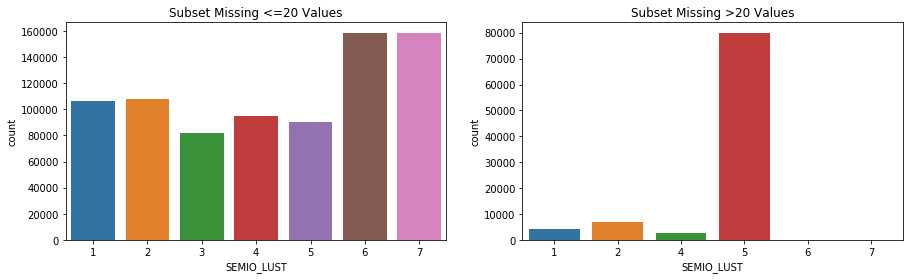

In [22]:
for i in range(len(target_cols)):
    plots_for_column(target_cols[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Since each row can have no more than 79 missing values, which is a relatively small number (<100), I created a histogram based on these numbers instead of finding proportions. The histogram showed a very clear separation of rows with less than 20 missing values and rows with more than 20 missing values, so that number was used to split the dataset. 

I then pulled five columns with the least amount of missing values: `ALTERSKATEGORIE_GROB` (0.323264%), `LP_STATUS_GROB` (0.544646%), `LP_STATUS_FEIN` (0.544646%), `ONLINE_AFFINITAET` (0.544646%), and `RETOURTYP_BK_S` (0.544646%). These columns were used to compare the distribution of values between the two subsets. The visualizations of these distributions show that the data with many missing values looks very different from the data with few or no missing values. Since the distributions are so different, there could be valuable information to draw from either subset. For the sake of this project, I will continue the analysis using just the subset of the data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info = feat_info[feat_info['attribute'].isin(less_missing.columns)]
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables
cat_variables = feat_info[feat_info['type'] == 'categorical']

binary_cats = []
multi_cats = []

# Loop through the categorical variables and sort into binary or multi-level
# containers
for variable in cat_variables['attribute']:
    if less_missing[variable].nunique() == 2:
        binary_cats.append(variable)
    else:
        multi_cats.append(variable)

In [25]:
#  Which are binary and which are multi-level?
print('Binary categoricals: \n{}'.format(binary_cats))
print('\nMulti-level categoricals: \n{}'.format(multi_cats))

Binary categoricals: 
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-level categoricals: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [26]:
# Which one needs to be re-encoded?
for variable in binary_cats:
    print(less_missing[variable].value_counts())

2    415781
1    381645
Name: ANREDE_KZ, dtype: int64
0    622259
1    175167
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790714
1.0      6712
Name: SOHO_KZ, dtype: int64
2.0    394161
1.0    366848
Name: VERS_TYP, dtype: int64
W    628987
O    168439
Name: OST_WEST_KZ, dtype: int64


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis
new_vals = {'W':0, 'O':1}
less_missing = less_missing.replace({'OST_WEST_KZ':new_vals})

for variable in binary_cats:
    print(less_missing[variable].value_counts())

2    415781
1    381645
Name: ANREDE_KZ, dtype: int64
0    622259
1    175167
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790714
1.0      6712
Name: SOHO_KZ, dtype: int64
2.0    394161
1.0    366848
Name: VERS_TYP, dtype: int64
0    628987
1    168439
Name: OST_WEST_KZ, dtype: int64


In [28]:
# Remove the multi-level categoricals from the analysis for simplicity
less_missing.drop(columns=multi_cats, axis='multi_cats', inplace=True)
less_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null int64
FINANZ_MINIMALIST        797426 non-null int64
FINANZ_SPARER            797426 non-null int64
FINANZ_VORSORGER         797426 non-null int64
FINANZ_ANLEGER           797426 non-null int64
FINANZ_UNAUFFAELLIGER    797426 non-null int64
FINANZ_HAUSBAUER         797426 non-null int64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
LP_LEBENSPHASE_FEIN      747775 non-null float64
LP_LEBENSPHASE_GROB      750596 non-null float64
PRAEGENDE_JUGENDJAHRE    768968 non-null float64
RETOURTYP_BK_S           792792 non-null float64
SEMIO_SOZ                797426 non-null int64
SEMIO_FAM                797426 non-null int64
SEMIO_REL                797426 non-null int64
SEMIO_MAT                797426 non-null int64
SEMIO_VERT               797426

#### Discussion 1.2.1: Re-Encode Categorical Features

18 categorical variables were found. Four of these variables were binary while the other 14 were multi-lvel. Of the four binary categoricals, only one required re-encoding from non-numeric values `"W"` and `"O"` to `0`and `1` respectively. In order to keep the dataset simple, I decided to drop the multi-level categoricals. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE"
less_missing['PRAEGENDE_JUGENDJAHRE']

1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
12         8.0
13        15.0
15         5.0
16        14.0
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
31        10.0
32        15.0
33         8.0
34         4.0
36         8.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 797426, dtype: float64

In [30]:
# Decade: 1=40s, 2=50s, 3=60s, 4=70s, 5=80s, 6=90s
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

# Movement: 1=Mainstream & 0=Avantgarde
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [31]:
# Engineer two new variables
less_missing['DECADE'] = less_missing['PRAEGENDE_JUGENDJAHRE']
less_missing['MOVEMENT'] = less_missing['PRAEGENDE_JUGENDJAHRE']

less_missing['DECADE'].replace(decade_dict, inplace=True)
less_missing['MOVEMENT'].replace(movement_dict, inplace=True)

# Remove the `PRAEGENDE_JUGENDJAHRE` variable since it now contains
# redundant data
less_missing.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

In [32]:
less_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null int64
FINANZ_MINIMALIST        797426 non-null int64
FINANZ_SPARER            797426 non-null int64
FINANZ_VORSORGER         797426 non-null int64
FINANZ_ANLEGER           797426 non-null int64
FINANZ_UNAUFFAELLIGER    797426 non-null int64
FINANZ_HAUSBAUER         797426 non-null int64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
LP_LEBENSPHASE_FEIN      747775 non-null float64
LP_LEBENSPHASE_GROB      750596 non-null float64
RETOURTYP_BK_S           792792 non-null float64
SEMIO_SOZ                797426 non-null int64
SEMIO_FAM                797426 non-null int64
SEMIO_REL                797426 non-null int64
SEMIO_MAT                797426 non-null int64
SEMIO_VERT               797426 non-null int64
SEMIO_LUST               797426 n

In [33]:
# Investigate "CAMEO_INTL_2015"
less_missing['CAMEO_INTL_2015']

1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
12         43
13         33
15         41
16         41
18         24
19         34
20         24
21         55
22         51
23         43
25         33
26        NaN
27         51
28         13
29         12
31         51
32         14
33         41
34         25
36         41
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 797426, dtype: object

In [34]:
# Wealth: 1=Wealthy, 2=Prosperous, 3=Comfortable, 4=Less Affluent, 5=Poor
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, 
               '21':2, '22':2, '23':2, '24':2, '25':2, 
               '31':3, '32':3, '33':3, '34':3, '35':3, 
               '41':4, '42':4, '43':4, '44':4, '45':4, 
               '51':5, '52':5, '53':5, '54':5, '55':5}

# Life stage: 1=Pre-family couples & single, 2=Young couples with children, 
# 3=Families with school age children, 4=Older families & mature couples, 
# 5=Elders in retirement
life_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, 
             '21':1, '22':2, '23':3, '24':4, '25':5, 
             '31':1, '32':2, '33':3, '34':4, '35':5, 
             '41':1, '42':2, '43':3, '44':4, '45':5, 
             '51':1, '52':2, '53':3, '54':4, '55':5}

In [35]:
# Engineer two new variables
less_missing['WEALTH'] = less_missing['CAMEO_INTL_2015']
less_missing['LIFE_STAGE'] = less_missing['CAMEO_INTL_2015']

less_missing['WEALTH'].replace(wealth_dict, inplace=True)
less_missing['LIFE_STAGE'].replace(life_dict, inplace=True)

# Remove the `CAMEO_INTL_2015` variable since it now contains
# redundant data
less_missing.drop("CAMEO_INTL_2015", axis=1, inplace=True)

In [36]:
less_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null int64
FINANZ_MINIMALIST        797426 non-null int64
FINANZ_SPARER            797426 non-null int64
FINANZ_VORSORGER         797426 non-null int64
FINANZ_ANLEGER           797426 non-null int64
FINANZ_UNAUFFAELLIGER    797426 non-null int64
FINANZ_HAUSBAUER         797426 non-null int64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
LP_LEBENSPHASE_FEIN      747775 non-null float64
LP_LEBENSPHASE_GROB      750596 non-null float64
RETOURTYP_BK_S           792792 non-null float64
SEMIO_SOZ                797426 non-null int64
SEMIO_FAM                797426 non-null int64
SEMIO_REL                797426 non-null int64
SEMIO_MAT                797426 non-null int64
SEMIO_VERT               797426 non-null int64
SEMIO_LUST               797426 n

#### Discussion 1.2.2: Engineer Mixed-Type Features

After investigating each of the mixed-value features and the `Data_Dictionary.md` file, I had enough information to understand how each feature needed to be separated. For `PRAEGENDE_JUGENDJAHRE` I created two new variables: `DECADE` using intervals and a binary `MOVEMENT`. And two interval variables `WEALTH` and `LIFE_STAGE` for `CAMEO_INTL_2015`. At this point both `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` contain redundant data, so I removed them from the dataset for simplicity.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_cols = feat_info[feat_info['type']=='mixed']['attribute']
for mixed_col in mixed_cols:
    if mixed_col in less_missing.columns:
        less_missing.drop(mixed_col, axis=1, inplace=True)

azdias_clean = less_missing

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # Identify missing or unknown data values and convert them to NaNs.
    for index in range(len(feat_info)):
        # Parse and clean `missing_or_unknown` values from `feat_info`
        nan_data = feat_info.iloc[index]['missing_or_unknown']
        nan_data = nan_data.strip('[]')
        nan_data = nan_data.split(sep=',')
    
    # If the missing or unknown value is not "X", "XX", or empty then convert to an int
    nan_data = [int(value) if (value != 'X' and value != 'XX' and value != '') 
                else value for value in nan_data]
    
    if nan_data != ['']:
        # Replace missing or unkown values with NaNs
        df = df.replace({feat_info.iloc[index]['attribute']: nan_data}, np.nan)
    
    
    # Remove selected columns and rows, ...
    drop_cols = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
    df.drop(columns=drop_cols, axis='drop_cols', inplace=True)
    
    df_clean = df[df.isnull().sum(axis=1) <= 20]
    
    
    # Select, re-encode, and engineer column values.
    feat_info = feat_info[feat_info['attribute'].isin(df_clean.columns)] 

    # Assess categorical variables 
    cat_variables = feat_info[feat_info['type'] == 'categorical'] 

    binary_cats = [] 
    multi_cats = [] 

    # Loop through the categorical variables and sort into binary or multi-level 
    # containers 
    for variable in cat_variables['attribute']: 
        if df_clean[variable].nunique() == 2: 
            binary_cats.append(variable) 
        else: 
            multi_cats.append(variable) 

    # Re-encode categorical variable(s) to be kept in the analysis 
    new_vals = {'W':0, 'O':1} 
    df_clean = df_clean.replace({'OST_WEST_KZ':new_vals}) 

    # Remove the multi-level categoricals from the analysis for simplicity 
    df_clean.drop(columns=multi_cats, axis='multi_cats', inplace=True) 

    # Decade: 1=40s, 2=50s, 3=60s, 4=70s, 5=80s, 6=90s 
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6} 

    # Movement: 1=Mainstream & 0=Avantgarde 
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0} 

     # Engineer two new variables 
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'] 
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE'] 

    df_clean['DECADE'].replace(decade_dict, inplace=True) 
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True) 

    # Remove the `PRAEGENDE_JUGENDJAHRE` variable since it now contains 
    # redundant data 
    df_clean.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True) 

    # Wealth: 1=Wealthy, 2=Prosperous, 3=Comfortable, 4=Less Affluent, 5=Poor 
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,  
                   '21':2, '22':2, '23':2, '24':2, '25':2,  
                   '31':3, '32':3, '33':3, '34':3, '35':3,  
                   '41':4, '42':4, '43':4, '44':4, '45':4,  
                   '51':5, '52':5, '53':5, '54':5, '55':5} 

    # Life stage: 1=Pre-family couples & single, 2=Young couples with children,  
    # 3=Families with school age children, 4=Older families & mature couples,  
    # 5=Elders in retirement 
    life_dict = {'11':1, '12':2, '13':3, '14':4, '15':5,  
                 '21':1, '22':2, '23':3, '24':4, '25':5,  
                 '31':1, '32':2, '33':3, '34':4, '35':5,  
                 '41':1, '42':2, '43':3, '44':4, '45':5,  
                 '51':1, '52':2, '53':3, '54':4, '55':5} 

    # Engineer two new variables 
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']

    df_clean['WEALTH'].replace(wealth_dict, inplace=True) 
    df_clean['LIFE_STAGE'].replace(life_dict, inplace=True) 
    
    df_clean['WEALTH'] = df_clean['WEALTH'].replace('XX', np.nan)
    df_clean['LIFE_STAGE'] = df_clean['LIFE_STAGE'].replace('XX', np.nan)

    # Remove the `CAMEO_INTL_2015` variable since it now contains 
    # redundant data 
    df_clean.drop("CAMEO_INTL_2015", axis=1, inplace=True) 

    # Do whatever you need to in order to ensure that the dataframe only contains 
    # the columns that should be passed to the algorithm functions. 
    mixed_cols = feat_info[feat_info['type']=='mixed']['attribute'] 

    for mixed_col in mixed_cols: 
        if mixed_col in df_clean.columns: 
            df_clean.drop(mixed_col, axis=1, inplace=True) 
            
    # Return the cleaned dataframe.
    return(df_clean)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [39]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
null_vals = azdias_clean.isnull().sum().sum()
print('Number of null values: {}'.format(null_vals))

Number of null values: 751879


In [40]:
null_vals = azdias_clean.isnull().sum()
null_vals.sort_values(ascending=False, inplace=True)
null_vals

REGIOTYP                 64433
KKK                      64433
W_KEIT_KIND_HH           58900
KBA05_ANTG4              39536
KBA05_ANTG2              39536
KBA05_ANTG3              39536
MOBI_REGIO               39536
KBA05_ANTG1              39536
KBA05_GBZ                39536
HEALTH_TYP               36417
VERS_TYP                 36417
DECADE                   28458
MOVEMENT                 28458
PLZ8_ANTG2               22729
PLZ8_ANTG1               22729
PLZ8_ANTG4               22729
PLZ8_HHZ                 22729
PLZ8_GBZ                 22729
PLZ8_ANTG3               22729
KBA13_ANZAHL_PKW         12257
ANZ_HAUSHALTE_AKTIV       6330
WEALTH                    6003
LIFE_STAGE                6003
RETOURTYP_BK_S            4634
ONLINE_AFFINITAET         4634
ARBEIT                    4218
RELAT_AB                  4218
ORTSGR_KLS9               4118
ANZ_HH_TITEL              3728
ALTERSKATEGORIE_GROB      2784
                         ...  
GEBAEUDETYP_RASTER           5
FINANZ_H

In [41]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797426 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     794642 non-null float64
ANREDE_KZ                797426 non-null int64
FINANZ_MINIMALIST        797426 non-null int64
FINANZ_SPARER            797426 non-null int64
FINANZ_VORSORGER         797426 non-null int64
FINANZ_ANLEGER           797426 non-null int64
FINANZ_UNAUFFAELLIGER    797426 non-null int64
FINANZ_HAUSBAUER         797426 non-null int64
GREEN_AVANTGARDE         797426 non-null int64
HEALTH_TYP               761009 non-null float64
RETOURTYP_BK_S           792792 non-null float64
SEMIO_SOZ                797426 non-null int64
SEMIO_FAM                797426 non-null int64
SEMIO_REL                797426 non-null int64
SEMIO_MAT                797426 non-null int64
SEMIO_VERT               797426 non-null int64
SEMIO_LUST               797426 non-null int64
SEMIO_ERL                797426 non-null int64
SEMIO_KULT               797426 non-n

In [42]:
# Because there are a lot of null values across different columns, 
# an imputer can be used to fill these with the most frequent value 
# within that column
nan_imputer = Imputer(strategy='most_frequent')

azdias_impclean = pd.DataFrame(nan_imputer.fit_transform(azdias_clean))
azdias_impclean.columns = azdias_clean.columns
azdias_impclean.index = azdias_clean.index

In [43]:
null_vals = azdias_impclean.isnull().sum().sum()
print('Number of null values: {}'.format(null_vals))

Number of null values: 0


In [44]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaclean = scaler.fit_transform(azdias_impclean)
azdias_scaclean = pd.DataFrame(azdias_scaclean, columns=azdias_impclean.columns.tolist())

azdias_scaclean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.010368,...,0.441766,1.455006,0.573846,-0.171603,-0.127145,0.684744,1.098531,0.530567,1.175734,-1.249157
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.010368,...,-0.935489,0.419154,0.573846,-0.171603,-0.127145,-0.789154,1.098531,-1.884775,-0.869674,0.766845
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.935489,-0.616697,0.573846,-1.173369,-0.997689,-0.052205,-0.267356,0.530567,-1.551476,-0.577156
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.010368,...,0.441766,-0.616697,-0.337337,0.830164,0.308127,1.421694,-0.267356,0.530567,0.493932,0.094845
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.010368,...,0.441766,1.455006,1.485029,-1.173369,-0.997689,-0.052205,-1.633243,0.530567,1.175734,0.766845


### Discussion 2.1: Apply Feature Scaling

Because sklearn requires that data not have missing values in order for its estimators to work properly, I began with investigating how many NaN values the clean dataset had. This turned out to be quite a large number (over 700k) and spanned 34 columns. Instead of removing all of these data points and potentially losing valuable information, I applied an Imputer to replace them with the most frequent value within that column. I chose the most frequent value to avoid introducing any values abnormal to the dataset. 

When it came to scaling the dataset, I chose to implement the suggested StandardScaler. This scaled each feature to a mean of 0 and a standard deviation of 1. This standardization of the dataset is important when ensuring that machine learning algorithms predict correctly.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaclean)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

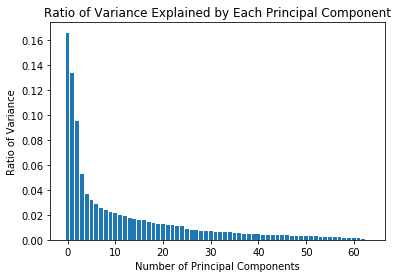

In [46]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_);
plt.title('Ratio of Variance Explained by Each Principal Component');
plt.xlabel('Number of Principal Components');
plt.ylabel('Ratio of Variance');

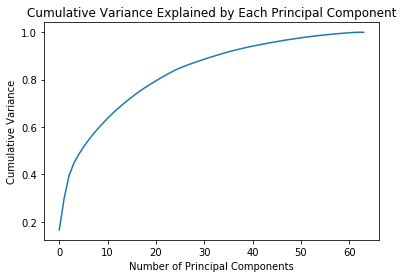

In [47]:
cum_vals = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(pca.explained_variance_ratio_)), cum_vals);
plt.title('Cumulative Variance Explained by Each Principal Component');
plt.xlabel('Number of Principal Components');
plt.ylabel('Cumulative Variance');

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)
azdias_pcaclean = pca_20.fit_transform(azdias_scaclean)

### Discussion 2.2: Perform Dimensionality Reduction

According to the plots above, keeping 20 principal components explains around 80% cumulative variances from the data. Retaining this number of components also reduces the number of features by over 2/3.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca, i):
    df_weights = pd.DataFrame(pca.components_, columns=list(azdias_scaclean.columns)).iloc[i]
    df_weights.sort_values(ascending=False, inplace=True)
    
    return df_weights

In [50]:
principal_one = map_weights(pca_20, 0)
print(principal_one)

PLZ8_ANTG3               0.225338
PLZ8_ANTG4               0.216950
WEALTH                   0.204676
HH_EINKOMMEN_SCORE       0.202271
ORTSGR_KLS9              0.196768
EWDICHTE                 0.194658
FINANZ_HAUSBAUER         0.159595
KBA05_ANTG4              0.154002
PLZ8_ANTG2               0.153675
FINANZ_SPARER            0.153008
ARBEIT                   0.142577
KBA05_ANTG3              0.136748
ANZ_HAUSHALTE_AKTIV      0.136056
RELAT_AB                 0.134957
SEMIO_PFLICHT            0.121078
SEMIO_REL                0.118514
DECADE                   0.112169
MOVEMENT                 0.110215
SEMIO_RAT                0.099493
SEMIO_TRADV              0.093647
SEMIO_MAT                0.082390
FINANZ_UNAUFFAELLIGER    0.080999
SEMIO_FAM                0.080974
SEMIO_KULT               0.075487
FINANZ_ANLEGER           0.075006
REGIOTYP                 0.060332
OST_WEST_KZ              0.053660
SEMIO_SOZ                0.043306
PLZ8_HHZ                 0.042252
HEALTH_TYP    

In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
principal_two = map_weights(pca_20, 1)
print(principal_two)

ALTERSKATEGORIE_GROB     0.256305
SEMIO_ERL                0.229949
FINANZ_VORSORGER         0.229251
SEMIO_LUST               0.180152
RETOURTYP_BK_S           0.161954
FINANZ_HAUSBAUER         0.121730
SEMIO_KRIT               0.117961
SEMIO_KAEM               0.116444
W_KEIT_KIND_HH           0.114787
PLZ8_ANTG3               0.098346
EWDICHTE                 0.097801
ORTSGR_KLS9              0.096491
PLZ8_ANTG4               0.096118
ANREDE_KZ                0.093196
WEALTH                   0.079151
KBA05_ANTG4              0.075148
SEMIO_DOM                0.074509
ARBEIT                   0.071737
RELAT_AB                 0.069221
PLZ8_ANTG2               0.068126
ANZ_HAUSHALTE_AKTIV      0.066394
HH_EINKOMMEN_SCORE       0.061816
FINANZ_MINIMALIST        0.059423
WOHNDAUER_2008           0.058443
KBA05_ANTG3              0.050483
VERS_TYP                 0.032204
ANZ_HH_TITEL             0.032056
OST_WEST_KZ              0.027438
MOVEMENT                 0.018369
PLZ8_HHZ      

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
principal_three = map_weights(pca_20, 2)
print(principal_three)

SEMIO_VERT               0.344672
SEMIO_SOZ                0.261895
SEMIO_FAM                0.248881
SEMIO_KULT               0.233828
FINANZ_MINIMALIST        0.154534
RETOURTYP_BK_S           0.109145
FINANZ_VORSORGER         0.101761
W_KEIT_KIND_HH           0.085191
ALTERSKATEGORIE_GROB     0.079762
SEMIO_REL                0.067786
SEMIO_LUST               0.064607
SEMIO_MAT                0.055617
ORTSGR_KLS9              0.050257
EWDICHTE                 0.049470
PLZ8_ANTG4               0.049101
PLZ8_ANTG3               0.048430
GREEN_AVANTGARDE         0.047102
ARBEIT                   0.037300
RELAT_AB                 0.034320
PLZ8_ANTG2               0.032681
WOHNDAUER_2008           0.032599
WEALTH                   0.030155
KBA05_ANTG4              0.029948
ANZ_HAUSHALTE_AKTIV      0.026779
OST_WEST_KZ              0.016277
ANZ_HH_TITEL             0.013923
KBA05_ANTG3              0.011816
ANZ_TITEL                0.009711
PLZ8_HHZ                 0.005569
VERS_TYP      

In [53]:
positive_vals = ['PLZ8_ANTG3', 'PLZ8_ANTG4', 'WEALTH', 'ALTERSKATEGORIE_GROB', 
                 'SEMIO_ERL', 'FINANZ_VORSORGER', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM']

negative_vals = ['PLZ8_ANTG1', 'MOBI_REGIO', 'FINANZ_MINIMALIST', 'SEMIO_REL', 
                 'DECADE', 'FINANZ_SPARER', 'ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM']

### Discussion 2.3: Interpret Principal Components

**1st Principal Component**
- Top 3 Positive Values:
    - `PLZ8_ANTG3` 0.225113 (Number of 6-10 family houses in the PLZ8 region)
    - `PLZ8_ANTG4` 0.216707 (Number of 10+ family houses in the PLZ8 region)
    - `WEALTH` 0.204511 (Wealth bracket)
- Top 3 Negative Values:
    - `PLZ8_ANTG1` -0.225470 (Number of 1-2 family houses in the PLZ8 region)
    - `MOBI_REGIO` -0.224858 (Movement patterns)
    - `FINANZ_MINIMALIST` -0.223368 (Financial typology: low financial interest)
- The first principal component corresponds to this: as the number of large family houses increase, small family houses will decrease. Also, wealth will increase while movement within the region and low financial interest decrease. More people living in one area will result in a general higher income for that region, which may influence people to not want to move out of the area and instead stay and spend their money in the area. 
   
**2nd Principal Component**
- Top 3 Positive Values:
    - `ALTERSKATEGORIE_GROB` 0.256059 (Estimated age based on given name analysis)
    - `SEMIO_ERL` 0.229830 (Personality typology: event-oriented)
    - `FINANZ_VORSORGER` 0.228709 (Financial typology: be prepared)
- Top 3 Negative Values:
    - `SEMIO_REL` -0.253286 (Personality typology: religious)
    - `DECADE` -0.238408 (Generation by decade)
    - `FINANZ_SPARER` -0.231265 (Financial typology: money-saver)
- The second principal component corresponds to this: as estimated age, event-oriented personalities, and prepared financial situations increase religion, generation by decade, and money-saver financial situations decrease. This principal component doesn't make too much sense to me, as one would think there would be positive correlations between age and generations as well as between prepared and money-saver financial typologies. 

**3rd Principal Component**
- Top 3 Positive Values:
    - `SEMIO_VERT` 0.344671 (Personality typology: dreamful)
    - `SEMIO_SOZ` 0.261865 (Personality typology: socially-minded)
    - `SEMIO_FAM` 0.248853 (Personality typology: family-minded)
- Top 3 Negative Values:
    - `ANREDE_KZ` -0.367298 (Gender)
    - `SEMIO_KAEM` -0.335030 (Personality typology: combative attitude)
    - `SEMIO_DOM` -0.313037 (Personality typology: dominant-minded)
- The third principal component corresponds to a lot of personality typologies. As dreamful, socially-minded, and family-minded personalities increase, combative and dominant-minded personalities decrease. This negative correlation makes sense because people who are more dreamful, socially-minded, and family-minded tend to be more docile or submissive as opposed to those who are combative and dominant. I am not exactly sure how to translate gender's role in this correlation, but it is positively correlated with the negative values.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
# Over a number of different cluster counts...
scores = []
clusters = list(range(1, 10))

for n in clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=n)
    model = kmeans.fit(azdias_pcaclean)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pcaclean))
    scores.append(score)

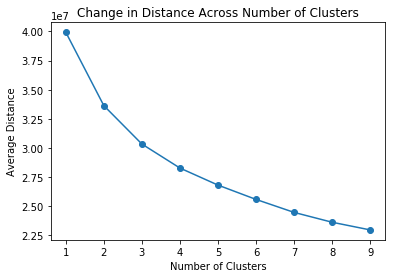

In [55]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, marker='o');
plt.title('Change in Distance Across Number of Clusters');
plt.xlabel('Number of Clusters');
plt.ylabel('Average Distance');

In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=6)
model = kmeans.fit(azdias_pcaclean)
azdias_clusters = model.predict(azdias_pcaclean)

### Discussion 3.1: Apply Clustering to General Population

Seeing as the plot created above is less linear and more curved, the "elbow" of the curve is a little more difficult to find. Using my own judgement, I decided to re-fit the k-means model with 6 clusters. This looks like the point at which adding more clusters no longer creates a substantial decrease in the average distance.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing: Wrangling, Selection, and Engineering
customers_clean = clean_data(customers)

In [59]:
# This section of code was provided by Matt from Udacity 
# (https://knowledge.udacity.com/questions/65620)
# and ensures that the columns between the two datasets are
# the exact same before applying transformations

# Find missing column(s)
def add_missing_dummy_cols(df, columns):
    missing_cols = set(columns) - set(df.columns)
    print('Missing column(s):', missing_cols)
    for c in missing_cols:
        df[c] = 0

# Find extra column(s) and fix the column(s)
def fix_cols(df, columns):
    add_missing_dummy_cols(df, columns)
    assert(set(columns) - set(df.columns) == set())
    extra_cols = set(df.columns) - set(columns)
    if extra_cols:
        print('Extra column(s):', extra_cols)
    df=df[columns]
    return df

customers_clean = fix_cols(customers_clean, azdias_clean.columns.tolist())

Missing column(s): {'VERS_TYP'}


In [60]:
# Feature transformations
# Imputer
customers_impclean = pd.DataFrame(nan_imputer.transform(customers_clean))
customers_impclean.columns = customers_clean.columns
customers_impclean.index = customers_clean.index

# Scaler
customers_scaclean = scaler.transform(customers_impclean)
customers_scaclean = pd.DataFrame(customers_scaclean, columns=customers_impclean.columns.tolist())

# PCA
customers_pcaclean = pca_20.transform(customers_scaclean)

In [61]:
# Cluster predictions
customers_clusters = model.predict(customers_pcaclean)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

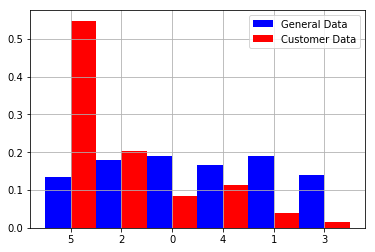

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# This section of code was provided by Rajat from Udacity 
# (https://knowledge.udacity.com/questions/905904)

# Generate proportion for `customers_clusters`
labels1, values1 = zip(*Counter(customers_clusters).items())
v1 = list(values1)
v1[:] = [x/len(customers_clusters) for x in v1]
indexes1 = np.arange(len(labels1))

# Generate proportion for `azdias_clusters`
labels2, values2 = zip(*Counter(azdias_clusters).items())
v2 = list(values2)
v2[:] = [x/len(azdias_clusters) for x in v2]
indexes2 = np.arange(len(labels2))

# Set up the plot
width = 0.5
plt.bar(indexes2, v2, width, color='b', label='General Data');
plt.bar(indexes1 + width, v1, width, color='r', label='Customer Data');
plt.xticks(indexes1 + width * 0.5, labels1);
plt.legend(loc='upper right');
plt.grid();

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_over = scaler.inverse_transform(pca_20.inverse_transform(model.cluster_centers_[5]))

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_under = scaler.inverse_transform(pca_20.inverse_transform(model.cluster_centers_[1]))

centroid_comparison = pd.DataFrame({'characteristic':customers_clean.columns, 
                                    'cluster_5':centroid_over, 
                                    'cluster_1':centroid_under})

In [68]:
centroid_comparison[centroid_comparison['characteristic'].isin(positive_vals)]

,characteristic,cluster_5,cluster_1
0,ALTERSKATEGORIE_GROB,3.333381,1.854327
4,FINANZ_VORSORGER,4.321545,2.189472
11,SEMIO_SOZ,5.040223,4.608880
12,SEMIO_FAM,4.776271,5.179417
15,SEMIO_VERT,6.032510,4.629584
17,SEMIO_ERL,4.281981,3.251859
53,PLZ8_ANTG3,1.051865,0.946989
54,PLZ8_ANTG4,0.278998,0.216085
62,WEALTH,2.483295,2.420673


In [69]:
centroid_comparison[centroid_comparison['characteristic'].isin(negative_vals)]

,characteristic,cluster_5,cluster_1
1,ANREDE_KZ,1.077703,1.421298
2,FINANZ_MINIMALIST,4.561622,2.853167
3,FINANZ_SPARER,1.588289,4.010174
13,SEMIO_REL,3.651930,5.706795
21,SEMIO_DOM,3.179557,4.135385
22,SEMIO_KAEM,2.649111,3.616040
47,MOBI_REGIO,3.796852,3.655807
51,PLZ8_ANTG1,2.787817,2.874415
60,DECADE,3.466286,5.740208


### Discussion 3.3: Compare Customer Data to Demographics Data

**Target Audience**
- Cluster 5 is overrepresented in the customer dataset compared to the general population. The people within this cluster represent the target audience for the company. Those who are part of the target audience have these characteristics:
    - `ALTERSKATEGORIE_GROB` 3.333381 (Estimated age based on given name analysis)
    - `FINANZ_VORSORGER` 4.321545 (Financial typology: be prepared)
    - `SEMIO_SOZ` 5.040223 (Personality typology: socially-minded)
    - `SEMIO_VERT` 6.032510 (Personality typology: dreamful)
    - `SEMIO_ERL` 4.281981 (Personality typology: event-oriented)
    - `PLZ8_ANTG3` 1.051865 (Number of 6-10 family houses in the PLZ8 region)
    - `PLZ8_ANTG4` 0.278998 (Number of 10+ family houses in the PLZ8 region)
    - `WEALTH` 2.483295 (Wealth bracket)
- The people who are typified by cluster 5 as being within the company's target audience are between the ages of 46-60, are financially prepared, have personalities that are socially-minded; dreamful; and event-oriented, have large families consisting of 6 - 10+ members, and are prosperously wealthy.

**Not the Target Audience**
- Clusters 0, 1, and 3 are underrepresented in the customer dataset compated to the general population. The people within these clusters are not the target audience for the company. Those who are not in the taget audience have these characteristics according to cluster 1:
    - `ANREDE_KZ` 1.421298 (Gender)
    - `FINANZ_SPARER` 4.010174 (Financial typology: money-saver)
    - `SEMIO_REL` 5.706795 (Personality typology: religious)
    - `SEMIO_DOM` 4.135385 (Personality typology: dominant-minded)
    - `SEMIO_KAEM` 3.616040 (Personality typology: combative attitude)
    - `PLZ8_ANTG1` 2.874415 (Number of 1-2 family houses in the PLZ8 region)
    - `DECADE` 5.740208 (Generation by decade)
- The people who are typified by cluster 1 as not belonging to the company's target audience are money-savers, have personalities that are religious; dominant-minded; and combative, have a small family consisting of 1 - 2 members, and experienced the economic miracle as the dominating movement of their youth.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.